In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
def create_df(input_file):
    """
    modify the file and add the category information
    """
    cars = pd.read_table('auto-mpg.data.txt', delim_whitespace = True, names = ('mpg', 'cylinders', 'displacement',
                                 'horsepower', 'weight', 'acceleration',
                                 'model year', 'origin', 'car name'))
    cars_df = cars.replace('?', np.nan)

    cars_df_input = cars_df.dropna().sort_values('mpg')
    cat_dict = {0: 'low', 1: 'medium', 2: 'high'}

    final_df = pd.DataFrame()

    for key, item in cat_dict.items():
        cat_df = np.array_split(cars_df_input, 3)[key]
        cat_df['category'] = item
        final_df = pd.concat([final_df, cat_df], axis = 0)
    final_df = final_df.sort_index()
    final_df.groupby('category').size()
    final_df['horsepower'] = final_df['horsepower'].astype(float)
    
    return final_df

In [3]:
def display_output(input_file):
    """display 2D scatterplot matrix"""
    final_df = create_df(input_file)
    final_df_graph = final_df[final_df.columns.difference(['mpg', 'car name'])]
    correlation = final_df_graph.corr()
    sns.set(color_codes=True)
    sns.set(style="white", palette="muted")
    sns.pairplot(final_df_graph, hue = 'category', diag_kind = 'hist')
    plt.show()
    plt.close()

In [4]:
def solver(dataframe, feature, order):
    """get the weights using OLS formula"""
    # initialize an array with 1
    intercept_value = np.ones((dataframe.shape[0], 1))
    if order == 0:
        X = intercept_value
    else:
        # keep adding the Xs into the array
        order_list = list(range(1, order + 1))
        X = intercept_value
        for order in order_list:
            x1 = np.array(dataframe[feature]**order).reshape(-1, 1)
            X = np.concatenate((X, x1), axis = 1)
    Y = np.array(dataframe['mpg']).T
    #OLS = (X^TX)^-1X^TY
    X_T_Y = np.dot(X.T, Y)
    weight_hat = np.dot(np.linalg.inv(np.dot(X.T, X)), X_T_Y)
    
    weight_list = weight_hat.tolist()
    
    return weight_list

In [5]:
def regression(training_set, test_set, feature, order):
    """
    regress on different order of polynomials and output a dataframe with predict values
    """
    weight = solver(training_set, feature, order)
    nrows = test_set.shape[0]
    predict_array = 0
    order_list = list(range(0, order + 1))
    for order in order_list:
        predict_array += weight[order] * test_set[feature] ** order 
    predict_df = pd.DataFrame(predict_array)
    test_set = test_set.reset_index()
    predict_df.columns = [str(order) + '_order']
    predict_df = predict_df.reset_index()
    final_output_df = pd.merge(test_set, predict_df, on = 'index')
    return final_output_df

In [6]:
def poly_graph(df_graph, feature, weight_list_dict):
    """ plot polynomial functions to the graph"""
    
    x_array = np.array(df_graph[feature])
    y_actual_array = np.array(df_graph['mpg'])

    plt.rcParams['figure.figsize'] = [10, 10]
    
    plt.plot(x_array, y_actual_array, 'o')
    
    df_graph = df_graph.sort_values(feature)
    
    X = np.array(df_graph[feature])
    Y = 0
    for key, weight_list in weight_list_dict.items():
        Y = 0
        for weight in weight_list:
            Y += weight * X ** (weight_list.index(weight))
        plt.plot(X, Y, label = 'order:' + str(key))
        plt.legend()
    plt.xlabel(feature)
    plt.ylabel('mpg')
    plt.show()
    plt.close()

In [7]:
def graph_order(training_set, test_set, feature):
    """plot the regression lines using the feature"""
    num_list = list(range(0, 4))
    weight_list_dict = {}

    for num in num_list:
        weight_list_dict[num] = solver(training_set, feature, num)

    # using test_set data
    poly_graph(test_set, feature, weight_list_dict)

In [8]:
def mean_squared_error(training_set, test_set, feature, order, actual):
    """ calculate the mean squared error"""
    nrows = test_set.shape[0]
    test_set = test_set.reset_index(drop = True)
    test_set.loc[:, str(order) + '_order'] = regression(training_set, test_set, feature, order)
    return round(np.average((test_set[actual] - test_set[str(order) + '_order'])**2, axis = 0), 5)

In [9]:
def print_mse(training_set, dataframe, order_check_list, feature_list):
    """print mse for dataframe"""
    for feature in feature_list:
        for num in order_check_list:
            print(str(feature) + "'s'" + str(num) + " order's mean squared error is", mean_squared_error(training_set, dataframe, feature, num, 'mpg'))
        print('\n')

In [10]:
def solver_multi(dataframe, feature_list, order):
    """
    get the weights using OLS formula for multiple features
    """
    intercept_value = np.ones((dataframe.shape[0], 1))
    if order == 0:
        X = intercept_value
    else:
        X = intercept_value
        
        order_list = list(range(1, order + 1))
        for order in order_list:
            ## add a for loop for features
            for feature in feature_list:
                x1 = np.array(dataframe[feature]**order).reshape(-1, 1)
                X = np.concatenate((X, x1), axis = 1)
    Y = np.array(dataframe['mpg']).T
    X_T_Y = np.dot(X.T, Y)
    weight_hat = np.dot(np.linalg.inv(np.dot(X.T, X)), X_T_Y)
    
    weight_list = weight_hat.tolist()
    
    return weight_list

In [11]:
def regression_multi(training_set, test_set, feature_list, order):
    """
    regress on different order of polynomials
    """
    test_set = test_set.reset_index(drop = True)
    weight = solver_multi(training_set, feature_list, order)
    intercept = weight[0]
    weight_array = np.array([weight[1:]]).T
    feature_df = test_set[feature_list]
    matrix_df = pd.DataFrame()
    order_list = list(range(1, order + 1))
    if order == 0:
        intercept_list = [intercept] * test_set.shape[0]
        final_matrix_df = pd.DataFrame(intercept_list, columns = ['predict'])
    else:
        for order in order_list:
            for col in feature_df.columns:
                new_df = pd.DataFrame(test_set[col] ** order)
                matrix_df = pd.concat([matrix_df, new_df], axis = 1)
        feature_matrix = matrix_df.values
        final_matrix_df = pd.DataFrame(np.add(np.matmul(feature_matrix, weight_array), intercept), columns = ['predict'])
    output_df = pd.concat([test_set, final_matrix_df], axis = 1)
    return output_df

In [12]:
def mean_squared_error_multi(training_set, test_set, feature_list, order, actual):
    """
    calculate the mean squared error for multi-variate polynomial function
    """
    final_df = regression_multi(training_set, test_set, feature_list, order)
    return round(np.average((final_df[actual] - final_df['predict'])**2, axis = 0), 2)

In [13]:
def print_mse_multi(training_set, dataframe, order_check_list, feature_list):
    """print mse for dataframe with multiple features"""
    order_multi_list = list(range(0, 3))
    # trainingset mean squared error
    for num in order_multi_list:
        print(str(num) + " order's mean squared error for is", mean_squared_error_multi(training_set, dataframe, feature_list, num, 'mpg'))
    print('\n')

In [14]:
def predict_display_output(input_file):
    final_df = create_df(input_file)
    
    # get a list of features
    feature_list = list(final_df[final_df.columns.difference(['mpg', 'car name', 'category'])].columns)
    # get a list of orders
    order_list = list(range(0, 4))
    
    final_df_sample = final_df.sample(frac = 1, random_state = 40)
    
    # get the training set
    training_set = final_df_sample[:200]
    
    # get the test set
    test_set = final_df_sample[200:]
    
    order_check_list = list(range(0, 4))
    
    for feature in feature_list:
        graph_order(training_set, test_set, feature)
    
    print('Mean Squared Error For Training Set:')
    print_mse(training_set, training_set, order_check_list, feature_list)
    print('Mean Squared Error For Test Set:')
    print_mse(training_set, test_set, order_check_list, feature_list)
    
    poly_list_dict = {}
    num_list = range(0, 5)
    for num in num_list:
        poly_list_dict[num] = solver_multi(training_set, feature_list, num)
    
    print('Mean Squared Error For Training Set:')
    print_mse_multi(training_set, training_set, order_check_list, feature_list)
    print('Mean Squared Error For Test Set:')
    print_mse_multi(training_set, test_set, order_check_list, feature_list)


In [15]:
def logistic_reg(input_file):
    """
    perform logistic regression
    """
    final_df = create_df(input_file)
    column_order_list = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
           'acceleration', 'model year', 'origin']
    feature_list = list(final_df[final_df.columns.difference(['mpg', 'car name', 'category'])].columns)
    ## create an array for independent variables
    X_data = np.array(final_df[final_df.columns.difference(['category','car name'])])
    ## create an array for dependent variables
    Y_data = np.array(final_df['category'])
    # split the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, stratify = Y_data, random_state = 42)
    # perform logistic regression
    log_reg = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 4000)
    clf = log_reg.fit(X_train, Y_train)
    Y_predict = log_reg.predict(X_train)
    
    print("The accuracy on the training set is {:.2%}".format(log_reg.score(X_train, Y_train)))
    print("The accuracy on the testing set is {:.2%}".format(log_reg.score(X_test, Y_test)))
    
    car_dict = {'cylinders': 6, 'displacement': 350, 'horsepower': 180, 'weight': 3700, 'acceleration': 9, 'model year': 80, 'origin': 1}
    
    car_predict_df = pd.DataFrame(car_dict, index = [0])
    
    # Use second-order, multi-variate polynomial to predict
    predict_df = regression_multi(final_df, car_predict_df, feature_list, order = 2)
    
    print('The expected MPG rating is', round(predict_df['predict'][0], 2))
    
    predict_df = predict_df.rename(columns = {'predict':'mpg'})
    
    predict_df = predict_df[column_order_list]
    
    Y_predict = clf.predict(np.array(predict_df))
    
    print('The mpg category is', Y_predict[0])


In [16]:
def final_output_display():
    input_file = input("Please enter the filename <'auto-mpg.data.txt'>: ")
    display_output(input_file)
    predict_display_output(input_file)
    logistic_reg(input_file)

Please enter the filename <'auto-mpg.data.txt'>: 'auto-mpg.data.txt'


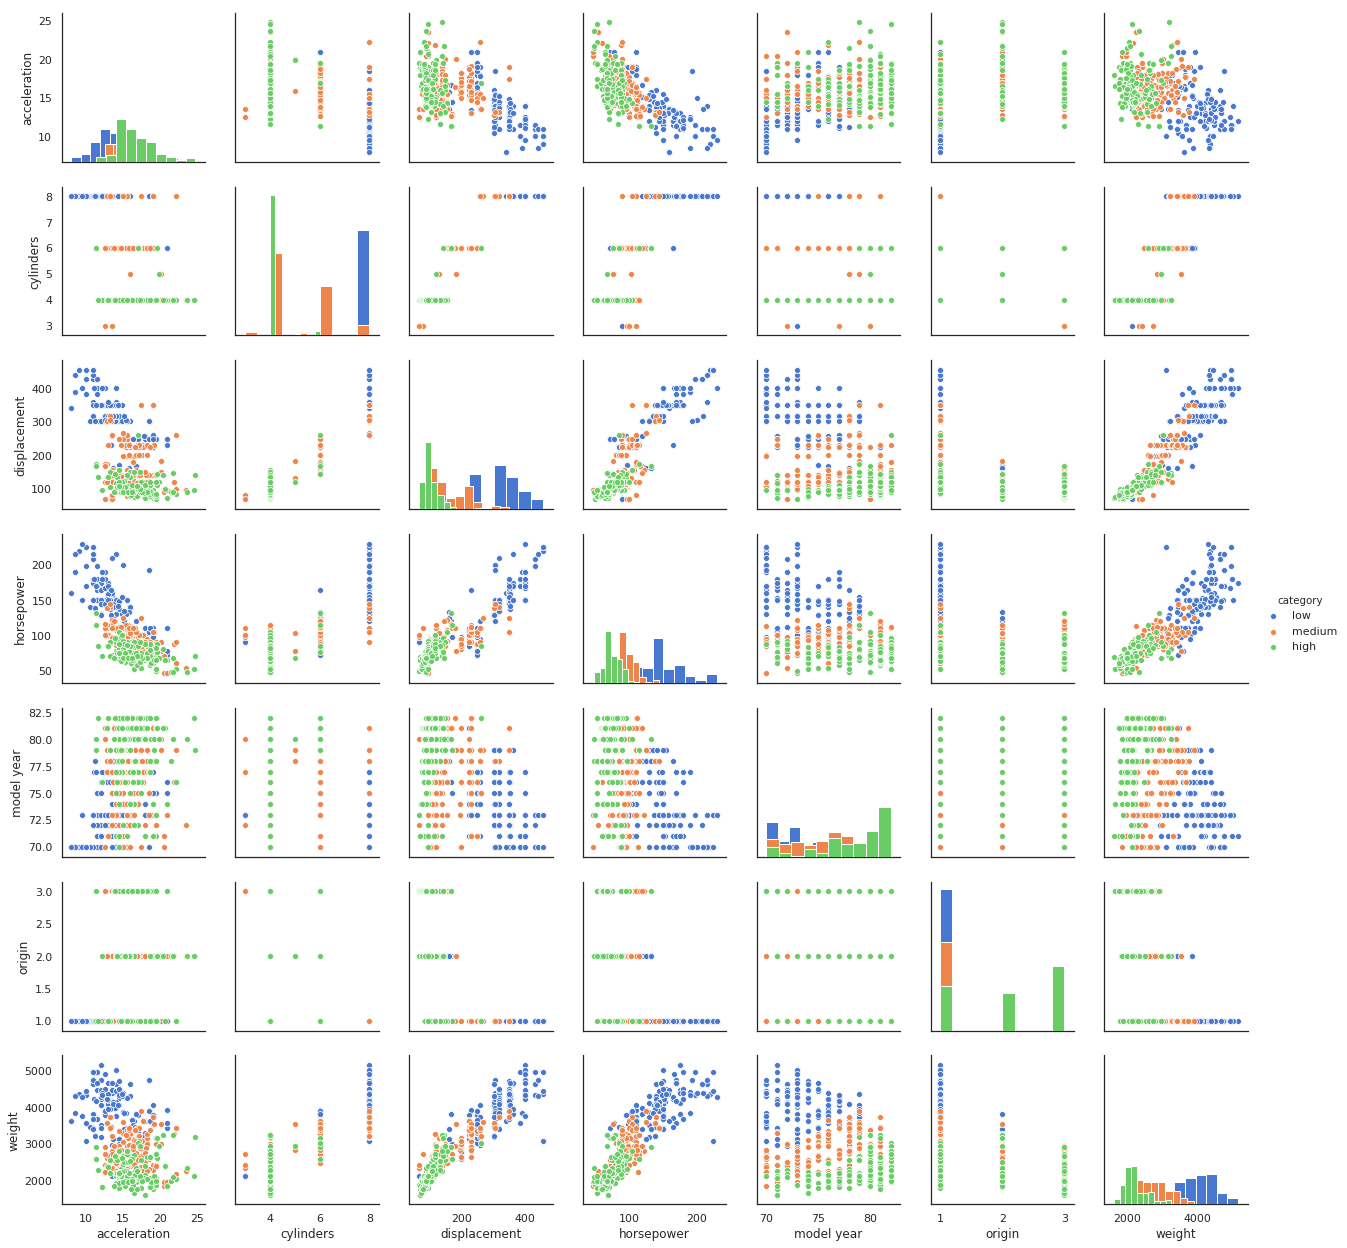

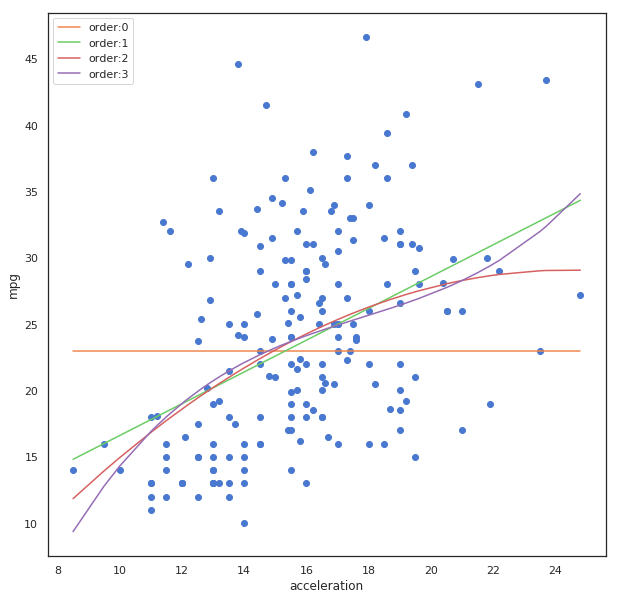

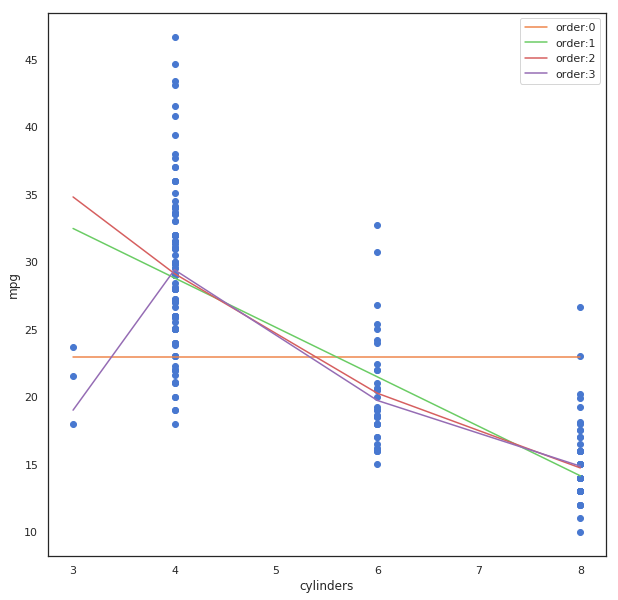

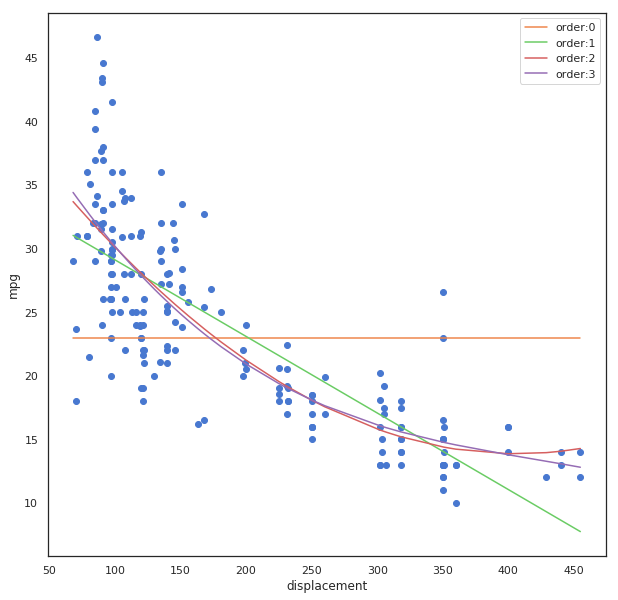

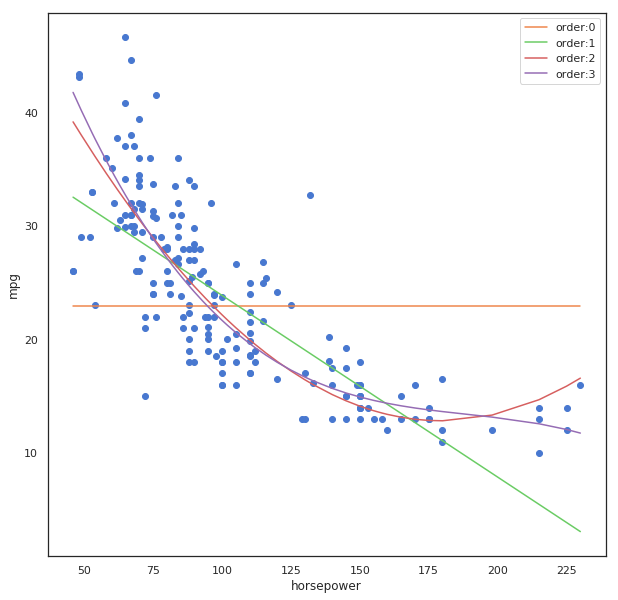

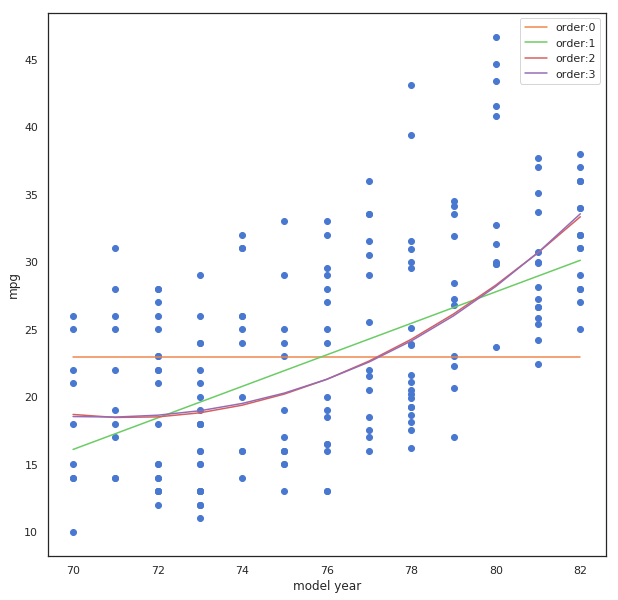

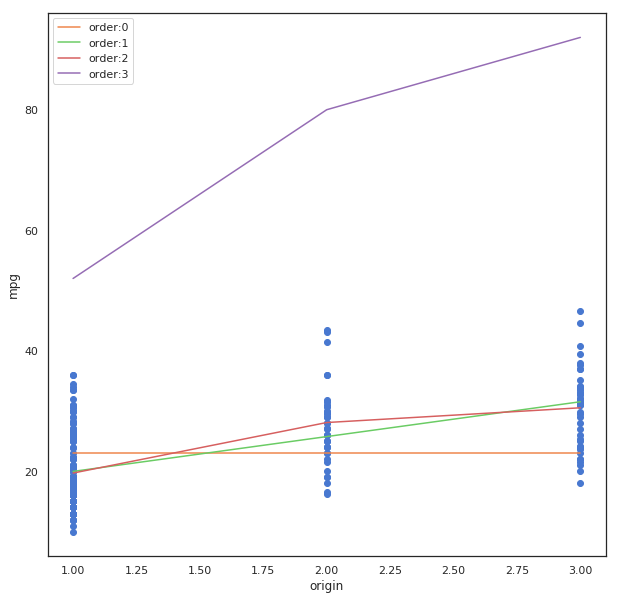

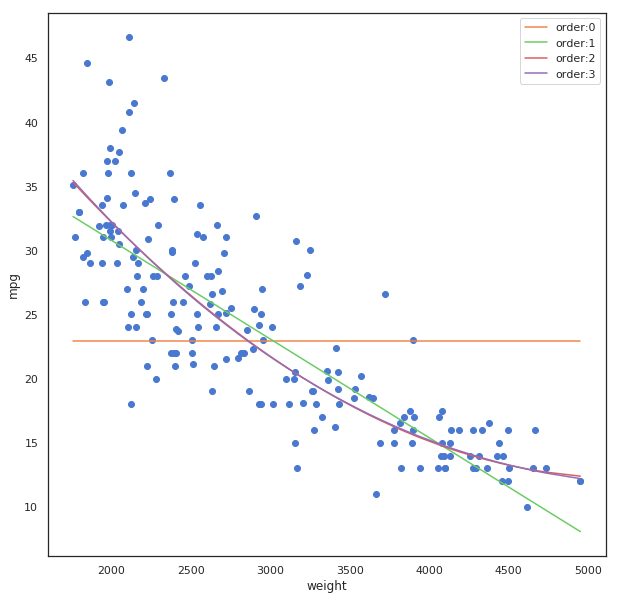

Mean Squared Error For Training Set:
acceleration's'0 order's mean squared error is 59.06319
acceleration's'1 order's mean squared error is 49.0194
acceleration's'2 order's mean squared error is 48.42065
acceleration's'3 order's mean squared error is 48.0136


cylinders's'0 order's mean squared error is 59.06319
cylinders's'1 order's mean squared error is 21.31451
cylinders's'2 order's mean squared error is 20.76854
cylinders's'3 order's mean squared error is 19.26468


displacement's'0 order's mean squared error is 59.06319
displacement's'1 order's mean squared error is 19.66003
displacement's'2 order's mean squared error is 16.88157
displacement's'3 order's mean squared error is 16.78953


horsepower's'0 order's mean squared error is 59.06319
horsepower's'1 order's mean squared error is 22.77429
horsepower's'2 order's mean squared error is 16.8092
horsepower's'3 order's mean squared error is 16.34371


model year's'0 order's mean squared error is 59.06319
model year's'1 order's mean 

In [17]:
final_output_display()